<a href="https://colab.research.google.com/github/gupann/CS269-Parking/blob/anmol-parallel-parking-static-obstacles-env/parallelparking_model_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model-Based Reinforcement Learning

## Parallel Parking
parking-parallel-dynObs-v0

In [1]:
# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# deleting old videos
import shutil
import os

folder_path = r"/home/aayush_wsl/cs269_rl_parking/CS269-Parking/videos"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Video Folder deleted.")
else:
    print("Video Folder does not exist.")

Video Folder deleted.


We also define a simple helper function for visualization of episodes:

In [2]:
import sys
from tqdm import trange # from tqdm.notebook import trange
# !pip install tensorboardx gym pyvirtualdisplay
# !apt-get install -y xvfb ffmpeg
# !git clone https://github.com/gupann/CS269-Parking.git 2> /dev/null
sys.path.insert(0, '/home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts')
from utils import record_videos, show_videos

In [3]:
# Environment
import gymnasium as gym
import highway_env

gym.register_envs(highway_env)

### Let's try it!

Make the environment, and run an episode with random actions:

Parallel Parking

In [4]:
# Configuration for parallel parking with custom dimensions
import numpy as np

parking_config = {
    # ===== PARKING SLOT DIMENSIONS =====
    "street_length": 80.0,      # Total length of street (default: 60.0)
                                # Increasing this makes parking spots wider
    
    "n_slots": 6,               # Number of slots per side (default: 8)
                                # Decreasing this makes parking spots wider
    
    # NOTE: Parking slot width = (street_length - 2*5.0) / n_slots
    # With above values: (80 - 10) / 6 = 11.67m per slot
    # Default: (60 - 10) / 8 = 6.25m per slot
    
    # ===== LANE DIMENSIONS =====
    "lane_width": 30.0,         # Width of central driving lane (default: 10.0)
                                # This is the vertical space for ego to maneuver
    
    "curb_offset": 15.0,        # Distance from center to parking rows (default: 10.0)
                                # Increase this to move parking spots farther from center
    
    # ===== GOAL/STARTING POSITIONS =====
    "empty_slot_index": 3,      # Which bottom slot is empty (0-based)
    
    # ===== ENVIRONMENT BOUNDARIES =====
    "wall_margin": 4.0,         # Extra space outside parking area
    "add_walls": True,          # Yellow boundary walls
    
    # ===== SIMULATION PARAMETERS =====
    "observation": {
        "type": "KinematicsGoal",
        "features": ["x", "y", "vx", "vy", "cos_h", "sin_h"],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False,
    },
    "action": {"type": "ContinuousAction"},
    "reward_weights": [1, 1, 0, 0, 0.2, 0.2],
    "success_goal_reward": 0.10, #Changed from 0.12 to 0.10 (Tighter)
    "collision_reward": -5,
    "steering_range": np.deg2rad(45),
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "duration": 100,
    "screen_width": 800,        # Wider screen for wider environment
    "screen_height": 400,       # Taller screen for wider lane
    "centering_position": [0.5, 0.5],
    "scaling": 5,               # Adjust zoom level (lower = more zoomed out)
    "show_trajectories": False,
    "controlled_vehicles": 1,
    "offscreen_rendering": False,
    "manual_control": False,
    "real_time_rendering": False,
}

# Calculate and display the resulting dimensions
slot_width = (parking_config["street_length"] - 10.0) / parking_config["n_slots"]
print(f"📏 Configuration Summary:")
print(f"  • Driving lane width: {parking_config['lane_width']} m")
print(f"  • Parking slot width: {slot_width:.2f} m")
print(f"  • Number of slots per row: {parking_config['n_slots']}")
print(f"  • Total street length: {parking_config['street_length']} m")

📏 Configuration Summary:
  • Driving lane width: 30.0 m
  • Parking slot width: 11.67 m
  • Number of slots per row: 6
  • Total street length: 80.0 m


In [5]:
# Test the dynamic obstacle environment
import gymnasium as gym
import highway_env

gym.register_envs(highway_env)

# Create environment
env = gym.make("parking-parallel-dynObs-v0", render_mode="rgb_array", config=parking_config)
env = record_videos(env)
obs, info = env.reset()

# Run a short episode to see the moving obstacle
for step in range(100):
    action = env.action_space.sample()  # Random action for testing
    obs, reward, done, truncated, info = env.step(action)
    
    # Print positions every 20 steps
    if step % 20 == 0:
        ego_pos = env.unwrapped.vehicle.position
        moving_obs = env.unwrapped.road.vehicles[1]  # The moving obstacle
        print(f"Step {step}:")
        print(f"  Ego position: {ego_pos}")
        print(f"  Moving obstacle position: {moving_obs.position}")
        print(f"  Moving obstacle speed: {moving_obs.speed} m/s")
    
    if done or truncated:
        break

env.close()
show_videos()
print("\n✅ Dynamic obstacle is working!")

Step 0:
  Ego position: [1.59928383e+01 2.84963356e-03]
  Moving obstacle position: [56.2  0. ]
  Moving obstacle speed: 1.0 m/s
Step 20:
  Ego position: [12.45028135  0.11148567]
  Moving obstacle position: [60.2  0. ]
  Moving obstacle speed: 1.0 m/s
Step 40:
  Ego position: [11.22842798  0.1085897 ]
  Moving obstacle position: [64.2  0. ]
  Moving obstacle speed: 1.0 m/s
Step 60:
  Ego position: [11.18296839  0.24069486]
  Moving obstacle position: [68.2  0. ]
  Moving obstacle speed: 1.0 m/s
Step 80:
  Ego position: [8.96627266 0.17147065]
  Moving obstacle position: [72.2  0. ]
  Moving obstacle speed: 1.0 m/s



✅ Dynamic obstacle is working!


In [6]:
env = gym.make("parking-parallel-dynObs-v0", render_mode="rgb_array", config=parking_config)
env = record_videos(env)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

/home/aayush_wsl/.pyenv/versions/3.10.13/envs/highway-env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/aayush_wsl/cs269_rl_parking/CS269-Parking/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Studying the environment, action space, reward  
1.) How and what modifications can be made to the environment  
2.) Figuring out how the action space looks like  
3.) How can I change the reward definition  
4.) How is collision detected in the environment  
5.) How is goal position specified in the environment  

In [7]:
print(env.unwrapped.config["observation"])

{'type': 'KinematicsGoal', 'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'], 'scales': [100, 100, 5, 5, 1, 1], 'normalize': False}


The environment is a `GoalEnv`, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy.

In [8]:
print("Observation format:", obs)

Observation format: OrderedDict([('observation', array([ 0.03145671, -0.01059317, -0.26831983, -0.05647787,  0.97855752,
        0.20597375])), ('achieved_goal', array([ 0.03145671, -0.01059317, -0.26831983, -0.05647787,  0.97855752,
        0.20597375])), ('desired_goal', array([ 0.45833333, -0.15      ,  0.        ,  0.        ,  1.        ,
        0.        ]))])


There is also an `achieved_goal` that won't be useful here (it only serves when the state and goal spaces are different, as a projection from the observation to the goal space).

Alright! We are now ready to apply the model-based reinforcement learning paradigm.

## Experience collection
First, we randomly interact with the environment to produce a batch of experiences

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [9]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=1000, action_repeat=2):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            if done:
              previous_obs, info = env.reset()
            obs, reward, done, truncated, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
            previous_obs = obs
    return data

env = gym.make("parking-parallel-dynObs-v0", render_mode="rgb_array", config=parking_config)
data = collect_interaction_data(env)
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([0.1600, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000]), action=tensor([-0.3303,  0.6706]), next_state=tensor([ 1.5979e-01, -6.1364e-05, -6.6062e-02,  1.6246e-04,  1.0000e+00,
        -2.4592e-03]))


## Build a dynamics model

We now design a model to represent the system dynamics. We choose  a **structured model** inspired from *Linear Time-Invariant (LTI) systems*

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

where the $(x, u)$ notation comes from the Control Theory community and stands for the state and action $(s,a)$. Intuitively, we learn at each point $(x_t, u_t)$ the **linearization** of the true dynamics $f$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [10]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt
    
    def get_linearization(self, x, u):
        """
        Get discrete-time linearization for iLQR
        Returns A_d, B_d such that x_{t+1} ≈ A_d @ x_t + B_d @ u_t
        :param x: state tensor [batch, state_size]
        :param u: action tensor [batch, action_size]
        :return: A_discrete [batch, state_size, state_size], 
                 B_discrete [batch, state_size, action_size]
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0
        
        # Compute continuous-time A and B
        A_cont = self.A2(F.relu(self.A1(xu)))
        A_cont = torch.reshape(A_cont, (x.shape[0], self.state_size, self.state_size))
        B_cont = self.B2(F.relu(self.B1(xu)))
        B_cont = torch.reshape(B_cont, (x.shape[0], self.state_size, self.action_size))
        
        # Convert to discrete time: x_{t+1} = x_t + (A*x + B*u)*dt
        # This gives: x_{t+1} = (I + A*dt)*x_t + (B*dt)*u_t
        batch_size = x.shape[0]
        I = torch.eye(self.state_size, device=x.device).unsqueeze(0).expand(batch_size, -1, -1)
        
        A_discrete = I + A_cont * self.dt
        B_discrete = B_cont * self.dt
        
        return A_discrete, B_discrete


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])
print("Forward initial model on a sample transition:",
      dynamics(data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[ 0.1794,  0.0467,  0.0193,  0.0149,  0.9768, -0.0692]])


## Fit the model on data
We can now train our model $f_\theta$ in a supervised fashion to minimize an MSE loss $L^2(f_\theta; D)$ over our experience batch $D$ by stochastic gradient descent:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

Train dynamics: 100%|██████████| 1500/1500 [00:07<00:00, 187.86it/s]


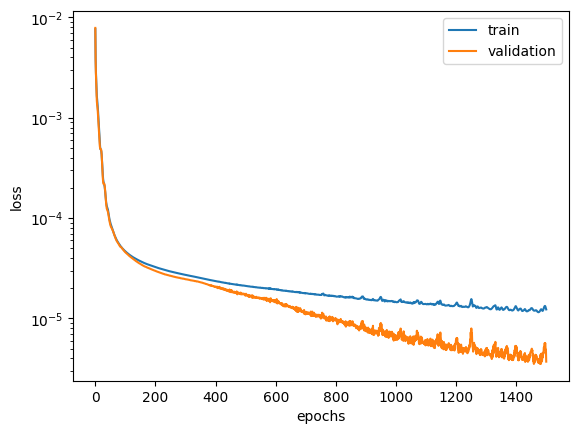

In [11]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in trange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["train", "validation"])
    plt.show()

train(dynamics, data, validation_data)

## Visualize trained dynamics

In order to qualitatively evaluate our model, we can choose some values of steering angle *(right, center, left)* and acceleration *(slow, fast)* in order to predict and visualize the corresponding trajectories from an initial state.  


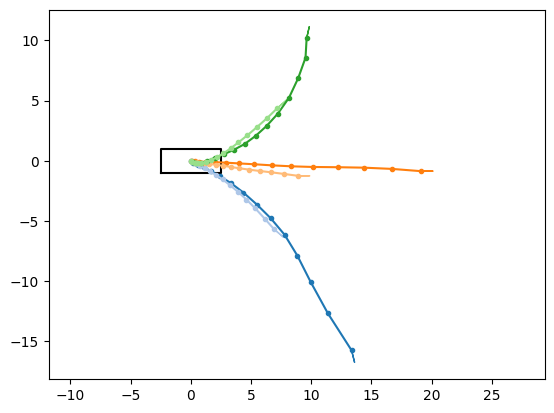

In [12]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()

visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

## Reward model
We assume that the reward $R(s,a)$ is known (chosen by the system designer), and takes the form of a **weighted L1-norm** between the state and the goal.

In [13]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

obs, info = env.reset()
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))
print(obs["desired_goal"])                                                     

Reward of a sample transition: tensor([-0.6696])
[ 0.45833333 -0.15        0.          0.          1.          0.        ]


## Leverage dynamics model for planning

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

This method approximates the optimal importance sampling estimator by repeating two phases:
1. **Draw samples** from a probability distribution. We use Gaussian distributions over sequences of actions.
2. Minimize the **cross-entropy** between this distribution and a **target distribution** to produce a better sample in the next iteration. We define this target distribution by selecting the top-k performing sampled sequences.

![Credits to Olivier Sigaud](https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/cem.png?raw=1)

Note that as we have a local linear dynamics model, we could instead choose an `Iterative LQR` planner which would be more efficient. We prefer `CEM` in this educational setting for its simplicity and generality.

In [ ]:
def ilqr_planner(state, goal, action_size, horizon=8, max_iters=3, lamb=10.0):
    """
    Iterative LQR planner using learned dynamics model (Robust version)
    
    :param state: current state [state_size]
    :param goal: goal state [state_size]
    :param action_size: dimension of action space
    :param horizon: planning horizon (reduced from 10 to 8)
    :param max_iters: number of iLQR iterations (reduced from 5 to 3)
    :param lamb: regularization parameter (increased for stability)
    :return: optimal first action
    """
    state_size = state.shape[0]
    device = state.device
    
    # Initialize with small random actions instead of zeros
    u_nominal = torch.randn(horizon, action_size, device=device) * 0.1
    
    # Clamp to action limits
    action_min = torch.tensor(env.action_space.low, device=device, dtype=torch.float32)
    action_max = torch.tensor(env.action_space.high, device=device, dtype=torch.float32)
    u_nominal = torch.clamp(u_nominal, action_min, action_max)
    
    # Cost weights (from reward weights)
    reward_weights = env.unwrapped.config["reward_weights"]
    Q_weights = torch.tensor(reward_weights, dtype=torch.float32, device=device)
    Q_goal = torch.diag(Q_weights)
    R = torch.eye(action_size, device=device, dtype=torch.float32) * 0.1
    
    best_cost = float('inf')
    best_u = u_nominal.clone()
    
    with torch.no_grad():  # Disable gradients for speed and stability
        for iteration in range(max_iters):
            try:
                # === FORWARD PASS: Rollout nominal trajectory ===
                x_nominal = torch.zeros(horizon + 1, state_size, device=device, dtype=torch.float32)
                x_nominal[0] = state
                
                for t in range(horizon):
                    x_next = dynamics(x_nominal[t].unsqueeze(0), 
                                     u_nominal[t].unsqueeze(0))
                    x_nominal[t + 1] = x_next.squeeze(0).detach()
                
                # Compute trajectory cost
                traj_cost = 0.0
                for t in range(horizon):
                    state_error = x_nominal[t] - goal
                    traj_cost += (state_error @ Q_goal @ state_error).item()
                    traj_cost += (u_nominal[t] @ R @ u_nominal[t]).item()
                
                # Keep best trajectory
                if traj_cost < best_cost:
                    best_cost = traj_cost
                    best_u = u_nominal.clone()
                
                # === BACKWARD PASS: Compute optimal gains ===
                V = Q_goal.clone()
                v = Q_goal @ (x_nominal[-1] - goal)
                
                k = torch.zeros(horizon, action_size, device=device, dtype=torch.float32)
                K = torch.zeros(horizon, action_size, state_size, device=device, dtype=torch.float32)
                
                backward_success = True
                for t in range(horizon - 1, -1, -1):
                    # Get linearization
                    try:
                        A, B = dynamics.get_linearization(x_nominal[t].unsqueeze(0), 
                                                         u_nominal[t].unsqueeze(0))
                        A, B = A.squeeze(0).detach(), B.squeeze(0).detach()
                    except:
                        backward_success = False
                        break
                    
                    # Quadratize cost
                    q = Q_goal @ (x_nominal[t] - goal)
                    r = R @ u_nominal[t]
                    
                    Q_x = q + A.T @ v
                    Q_u = r + B.T @ v
                    Q_xx = Q_goal + A.T @ V @ A
                    Q_uu = R + B.T @ V @ B
                    Q_ux = B.T @ V @ A
                    
                    # Strong regularization for numerical stability
                    Q_uu_reg = Q_uu + lamb * torch.eye(action_size, device=device, dtype=torch.float32)
                    
                    # Compute gains with error handling
                    try:
                        Q_uu_inv = torch.linalg.inv(Q_uu_reg)
                    except:
                        try:
                            Q_uu_inv = torch.linalg.pinv(Q_uu_reg)
                        except:
                            backward_success = False
                            break
                    
                    k[t] = -Q_uu_inv @ Q_u
                    K[t] = -Q_uu_inv @ Q_ux
                    
                    # Update value function
                    V = Q_xx - K[t].T @ Q_uu @ K[t]
                    v = Q_x - K[t].T @ Q_uu @ k[t]
                
                if not backward_success:
                    # If backward pass failed, return best action so far
                    break
                
                # === FORWARD PASS: Apply gains ===
                x_new = torch.zeros(horizon + 1, state_size, device=device, dtype=torch.float32)
                u_new = torch.zeros(horizon, action_size, device=device, dtype=torch.float32)
                x_new[0] = state
                
                alpha = 0.5  # Conservative step size
                
                for t in range(horizon):
                    # Compute new control with gains
                    du = alpha * k[t] + K[t] @ (x_new[t] - x_nominal[t])
                    u_new[t] = u_nominal[t] + du
                    
                    # Clamp to action limits
                    u_new[t] = torch.clamp(u_new[t], action_min, action_max)
                    
                    # Rollout
                    x_next = dynamics(x_new[t].unsqueeze(0), u_new[t].unsqueeze(0))
                    x_new[t + 1] = x_next.squeeze(0).detach()
                
                # Update nominal trajectory
                u_nominal = u_new.clone()
                
            except Exception as e:
                # If anything fails, return best action found
                print(f"iLQR iteration {iteration} failed: {e}")
                break
    
    # Return first action from best trajectory
    return best_u[0].clone()


# Test the planner on a sample transition
print("Testing iLQR planner...")
try:
    action = ilqr_planner(torch.Tensor(obs["observation"]),
                          torch.Tensor(obs["desired_goal"]),
                          env.action_space.shape[0],
                          horizon=8,
                          max_iters=3,
                          lamb=10.0)
    print("Planned action:", action.numpy())
    print("Action magnitude:", torch.norm(action).item())
except Exception as e:
    print(f"iLQR planner failed: {e}")
    # Fallback to simple action
    action = torch.Tensor([0.5, 0.0])
    print("Using fallback action:", action.numpy())


# Test the planner on a sample transition
# action = ilqr_planner(torch.Tensor(obs["observation"]),
#                       torch.Tensor(obs["desired_goal"]),
#                       env.action_space.shape[0],
#                       horizon=10)
# print("Planned action:", action)

Planned action: tensor([ 0.0393, -0.0131], grad_fn=<SelectBackward0>)


## Quick Diagnostic Script  
1.) To address issues like non-moving ego vehicle

In [15]:
print("="*60)
print("DIAGNOSTIC CHECK")
print("="*60)

# 1. Check if model was trained
print("\n1. Model parameters (first few):")
print(list(dynamics.parameters())[0][0, :5])

# 2. Check action space
print("\n2. Action space:")
print(f"   Low: {env.action_space.low}")
print(f"   High: {env.action_space.high}")

# 3. Test model prediction
obs, info = env.reset()
test_action = torch.Tensor([0.5, 0.2])
current = torch.Tensor(obs["observation"])
predicted = dynamics(current.unsqueeze(0), test_action.unsqueeze(0))
print("\n3. Model prediction test:")
print(f"   Current position: {current[:2].numpy()}")
print(f"   Predicted position: {predicted.squeeze()[:2].detach().numpy()}")
print(f"   Position change: {(predicted.squeeze()[:2] - current[:2]).detach().numpy()}")

# 4. Test linearization extraction (NEW!)
print("\n4. Model linearization test:")
A, B = dynamics.get_linearization(current.unsqueeze(0), test_action.unsqueeze(0))
print(f"   A matrix shape: {A.shape}")
print(f"   B matrix shape: {B.shape}")
print(f"   A matrix determinant: {torch.linalg.det(A).item():.4f}")

# 5. Test iLQR planner (CHANGED FROM CEM)
print("\n5. iLQR planner test:")
action = ilqr_planner(current, torch.Tensor(obs["desired_goal"]), 
                      env.action_space.shape[0], horizon=10)
print(f"   Planned action: {action.numpy()}")
print(f"   Action magnitude: {torch.norm(action).item()}")

print("\n" + "="*60)

DIAGNOSTIC CHECK

1. Model parameters (first few):
tensor([ 0.3207,  0.2939, -0.0472, -0.0927, -0.4857], grad_fn=<SliceBackward0>)

2. Action space:
   Low: [-1. -1.]
   High: [1. 1.]

3. Model prediction test:
   Current position: [0.16 0.  ]
   Predicted position: [ 0.160698   -0.00019379]
   Position change: [ 0.000698   -0.00019379]

4. Model linearization test:
   A matrix shape: torch.Size([1, 6, 6])
   B matrix shape: torch.Size([1, 6, 2])
   A matrix determinant: 0.9356

5. iLQR planner test:


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
print(env.unwrapped.config["reward_weights"])

## Visualize a few episodes

En voiture, Simone !

In [ ]:
env = gym.make("parking-parallel-dynObs-v0", render_mode='rgb_array', config=parking_config)
env = record_videos(env)
obs, info = env.reset()

for step in trange(3*env.unwrapped.config["duration"], desc="Testing 3 episodes with iLQR..."):
    action = ilqr_planner(torch.Tensor(obs["observation"]),
                         torch.Tensor(obs["desired_goal"]),
                         env.action_space.shape[0],
                         horizon=10,      # Longer horizon than CEM needed
                         max_iters=5)     # Fewer iterations needed
    obs, reward, done, truncated, info = env.step(action.numpy())
    if done or truncated:
        obs, info = env.reset()
env.close()
show_videos()

In [ ]:
#Analysis of the results
print('Desired Goal: ', obs['desired_goal'])
print('Observed Goal: ', obs['observation'][:2])
print('Action Taken: ', action)
print('Reward: ', reward)
print('Done: ', done)
print('Truncated: ', truncated)
print('Info: ', info)